# Creating and working with pure substance phase diagrams

## Goal of this notebook

- Learn how to generate and work with phase diagrams.
- Learn what `PhaseEquilibrium` objects are and how to use them.

## Important objects from `feos`

In the following we need:

- SI units via the `feos.si` module,
- `PcSaftParameters` and `Contributions` objects from the `feos.pcsaft` module, and
- `PcSaft`, `State`, `PhaseEquilibrium` and `PhaseDiagramPure` objects from `feos.pcsaft.eos` modules.
- Furthermore, we use `numpy` and `pandas` for arrays and `DataFrames`, respectively,
- and `matplotlib` and `seaborn` for visualization.

In [1]:
from feos.si import *
from feos.pcsaft import Contributions, PcSaftParameters
from feos.pcsaft.eos import PcSaft, State, PhaseEquilibrium, PhaseDiagramPure

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')
colors = sns.palettes.color_palette('Dark2', 8)

## Read parameters from json for a single substance and generate `PcSaft` object

In [2]:
parameters = PcSaftParameters.from_json(['hexane'], '../parameters/pcsaft/gross2001.json')
parameters

|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|
|-|-|-|-|-|-|-|-|-|-|-|
|hexane|86.177|3.0576|3.7983|236.77|0|0|0|0|1|1|

In [3]:
pcsaft = PcSaft(parameters)

## Generate `PhaseDiagramPure`

A `PhaseDiagramPure` object contains multiple thermodyanmic states of a pure substance at phase equilibrium.
It can be constructed by providing 

- an equation of state,
- the minimum temperature, and
- the number of points to compute.

The points are evenly distributed between the defined minimum temperature and the critical temperature which is either computed (default) or can be provided via the `critical_temperature` argument.

Furthermore, we can define options for the numerics:
- `max_iter` to define the maximum number of iterations for the phase equilibrium calculations, and
- `tol` to set the tolerance used for deterimation of phase equilibria.

A `Verbosity` (from the `feos.pcsaft` module) object can be provided via the `verbosity` argument to print intermediate calculations to the screen.

Starting from the minimum temperature, phase equilibria are computed in sequence using prior results (i.e. at prior temperature) as input for the next iteration.

In [4]:
phase_diagram = PhaseDiagramPure(pcsaft, min_temperature=200*KELVIN, npoints=501)

### Stored information

A `PhaseDiagramPure` object contains the following fields and methods:

- `states`: a list (with length of `npoints`) of `PhaseEquilibrium` objects at the different temperatures,
- lists for properties as `SINumber`s
    - pressures,
    - temperatures,
    - liquid and vapor densities,
    - liquid and vapor enthalpies, and
    - liquid and vapor entropies
- The `to_dict` method, which can be used to conveniently generate a `pandas.DataFrame` object (see below).

### Building a `pandas.DataFrame`: the `to_dict` method


The `PhaseDiagramPure` object contains some physical properties (such as densities, temperatures and pressures) as well as the `PhaseEquilibrium` objects at each temperature.

Before we take a look at these objects, a useful tool when working with phase diagrams is the `to_dict` method. It generates a Python dictionary of some properties (with hard-coded units, see the docstring of `to_dict`). This dictionary can readily be used to generate a `pandas.DataFrame`.

In [5]:
df = pd.DataFrame(phase_diagram.to_dict())
df.head()

,molar enthalpy vapor,density liquid,temperature,molar enthalpy liquid,density vapor,pressure,molar entropy liquid,molar entropy vapor
0,-16.735400,8539.589591,200.000000,-54.057307,0.012216,20.312763,-0.183475,0.003135
1,-16.639176,8532.663964,200.638669,-53.920803,0.013078,21.816282,-0.182794,0.003021
2,-16.542786,8525.749142,201.277337,-53.784188,0.013994,23.418684,-0.182114,0.002912
3,-16.446230,8518.845002,201.916006,-53.647463,0.014967,25.125608,-0.181436,0.002806
4,-16.349508,8511.951422,202.554674,-53.510626,0.015999,26.942961,-0.180759,0.002703


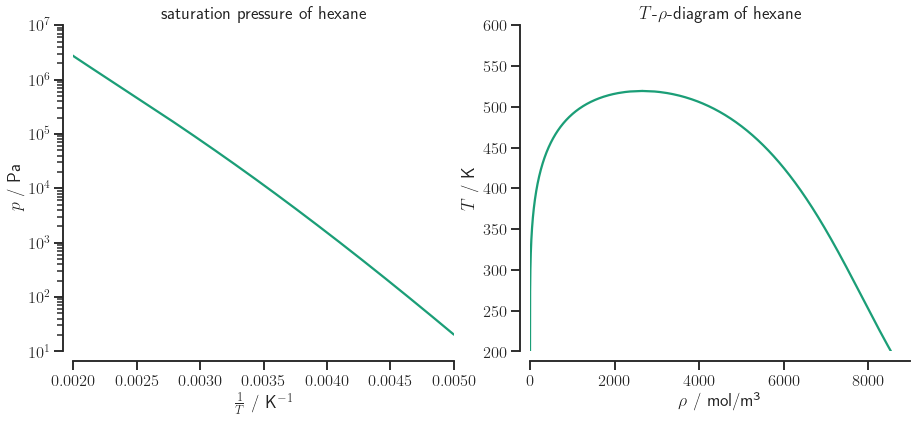

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].set_title(f"saturation pressure of {parameters.pure_records[0].identifier.name}")
sns.lineplot(y=df.pressure, x=1.0/df.temperature, ax=ax[0])

# axis and styling 
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$\frac{1}{T}$ / K$^{-1}$');
ax[0].set_ylabel(r'$p$ / Pa');
ax[0].set_xlim(0.002, 0.005)
ax[0].set_ylim(1e1, 1e7)

ax[1].set_title(r"$T$-$\rho$-diagram of {}".format(parameters.pure_records[0].identifier.name))
sns.lineplot(y=df.temperature, x=df['density vapor'], ax=ax[1], color=colors[0])
sns.lineplot(y=df.temperature, x=df['density liquid'], ax=ax[1], color=colors[0])

# axis and styling 
ax[1].set_ylabel(r'$T$ / K');
ax[1].set_xlabel(r'$\rho$ / mol/m³');
ax[1].set_ylim(200, 600)
ax[1].set_xlim(0, 9000)

sns.despine(offset=10)

## The `PhaseEquilibrium` object

A `PhaseEquilibrium` object contains two `State` objects that are in thermal, mechanical and chemical equilibrium.
There are two ways to construct such an object for a pure substance:

- `PhaseEquilibrium.pure_p` which creates a liquid and vapor state in equilibrium for a pure substance given a pressure, and
- `PhaseEquilibrium.pure_t` which creates a liquid and vapor state in equilibrium for a pure substance given a temperature.

In [7]:
vle = PhaseEquilibrium.pure_t(pcsaft, temperature=300.0*KELVIN)
vle

||temperature|density|
|-|-|-|
|phase 1|300.00000 K|8.86860  mol/m³|
|phase 2|300.00000 K|7.51850 kmol/m³|


The two equilibrium states can be extracted via `liquid` and `vapor`. Returned are `State` objects, for which we can now compute any property that is available for the `State` object and the given equation of state.

In [8]:
liquid = vle.liquid
vapor = vle.vapor

assert((liquid.pressure() - vapor.pressure()) / BAR < 1e-10)
print(f'saturation pressure      p_sat(T = {liquid.temperature}) = {liquid.pressure() / BAR:6.2f} bar')
print(f'enthalpy of vaporization h_lv (T = {liquid.temperature}) = {(vapor.specific_enthalpy() - liquid.specific_enthalpy()) / (KILO*JOULE/KILOGRAM):6.2f} kJ/kg')

saturation pressure      p_sat(T = 300 K) =   0.22 bar
enthalpy of vaporization h_lv (T = 300 K) = 365.83 kJ/kg


If you want to compute a boiling temperature or saturation pressure without needing the `PhaseEquilibrium` object you can use the

- `PhaseEquilibrium.boiling_temperature` and
- `PhaseEquilibrium.vapor_pressure`

methods. Note that these methods return lists (even for pure substance systems) where each entry contains the pure substance property.

In [9]:
PhaseEquilibrium.boiling_temperature(pcsaft, liquid.pressure())[0]

300.00000000050494 K

## The `states` method returns all `PhaseEquilibrium` objects from `PhaseDiagramPure`

Once a `PhaseDiagramPure` object is created, we can access all underlying `PhaseEquilibrium` objects via the `states` method.
In the following cell, we compute the enthalpy of vaporization by iterating through all states and calling the `specific_enthalpy` method on the vapor and liquid states of the `PhaseEquilibrium` object, respectively.

Note that this is merely an example to show how to compute any property of the states. The total value of enthalpy of vaporization may not be correct, depending on the ideal gas model used.

In [10]:
# Add enthalpy of vaporization to dataframe
df['hlv'] = [(vle.vapor.specific_enthalpy() - vle.liquid.specific_enthalpy()) / (KILO * JOULE / KILOGRAM) for vle in phase_diagram.states]

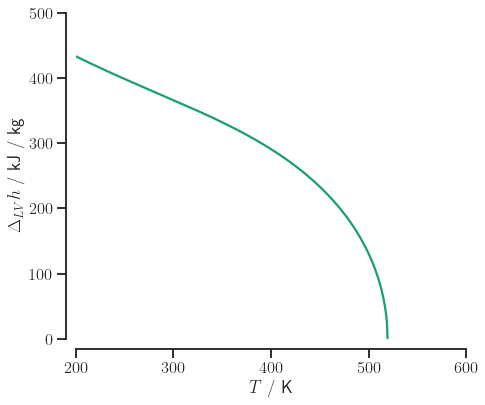

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.lineplot(y=df.hlv, x=df.temperature, ax=ax)

# axis and styling 
ax.set_xlabel(r'$T$ / K');
ax.set_ylabel(r'$\Delta_{LV} h$ / kJ / kg');
ax.set_xlim(200, 600)
ax.set_ylim(0, 500)

sns.despine(offset=10)